# Identifying Differentially Expressed Genes for MixScape Pipeline

I've personally found that the normal t-test method MixScape doesn't work that detect a large number of differentially expressed genes in comparison to using DESeq2 via psuedo bulking. As such I am using DESeq2 via psuedo bulking to identify differentially expressed genes

## Loading Package Dependencies

Following section of code setups the computational environment to conduct Quality Control and Merge experimental replicates. First I load the R packages that my analysis is dependent upon. Next are the utility functions to conduct repeative/routine steps of anaylsis. Finally, I load the merged SCE Objects and gRNA Count matrices.

In [1]:
# Data Cleaning packages
library(rlist)
library(tidyverse)
library(data.table)
library(hrbrthemes)
library(RColorBrewer)
library(org.Hs.eg.db)

# Single Cell Experiment Packages
library(DT)
library(fgsea)
library(scran)
library(scater)
library(DESeq2)
library(Seurat)
library(ggvenn)
library(viridis)
library(pheatmap)
library(gridExtra)
library(clusterProfiler)
library(SingleCellExperiment)

data_dir = '../data'
padj_palette = brewer.pal(n = 7, name = "Reds")
logfc_palette = brewer.pal(n = 7, name = "RdBu")

genes_levels <- c('MYC', 'MTOR', 'NCOA3', 'TFAP2C', 'GATA3', 'FOXA1', 'MED1', 'ESR1',
                  'CCND1', 'SMC1A', 'CREBBP', 'AKT1', 'MED12', 'TP53', 'CARM1',
                  'SMARCA4', 'NCOA5', 'EP300', 'PTEN', 'RBI', 'E2F1', 'GDF2', 'NPSR1',
                  'BPIFB3', 'CLDN17', 'FCRL4', 'IRGC', 'MEP1A', 'PRB1', 'SPATA16', 'PNPLA5')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following o

In [2]:
gene_metadata = read.csv(paste0(data_dir, '/Metadata/gene_metadata.csv'))
colnames(gene_metadata) = c('Gene_Symbol', 'Category', 'Essentiality')
gene_metadata$Gene_Symbol = as.character(gene_metadata$Gene_Symbol)
rownames(gene_metadata) = gene_metadata$Gene_Symbol

all_genes = gene_metadata %>% pull(Gene_Symbol)
expressed_genes = gene_metadata %>% filter(Essentiality != 'Non-essential') %>% pull(Gene_Symbol)
er_early = read.csv(paste0(data_dir, '/Metadata/er_early_response.csv'))

## Differential Expression Analysis - Utility Functions 

The function below implents a series of utility of functions to conduct and analysis differentially expressed analysis. 

- **conduct_dea_with_deseq2:** Conduct initial modelling of gene expression using DESeq2 and filter the initial matrix by removing all genes with less 10. Finally, aftering modeling gene expression per conduction we save the DESeq2 object.

- **fetch_dea_results:** With the provided DESeq2 object extract the DEA results using the results function and then shrink the log fold change using the lcfShrink function both are from the DESeq package. To do this I loop through all predefined conductions (in this case target genes). Once all of the results are extracted I then save the extracted DEA results.

- **find_deg_of_target_genes:** This function is responsible for extracting all unique differentially expressed gene from all target genes. What i mean is that if a gene is differentially expressed for any target gene I want to extract that. I then return this list. The extracted list will be used to extract genes in the extract_de_results and generate a heatmap.

- **extract_de_results:** Using the list returned from find_deg_of_target_genes we extract log fold change and adjusted p-values to generate a heatmap. adjusted p-values are also log transformed in order to better visual differences in expression.

- **heatmap_matrix:** Finally, using the values from differentially expressed genes generate a heatmap showing the differences in gene expression between the different target genes.

In [3]:
conduct_dea_with_deseq2 = function(dds, cache_fp) {
  # Remove genes with low counts
  keep = rowSums(counts(dds)) >= 10
  dds = dds[keep,]
  
  # estimate size factors and train deseq2 model
  dds = estimateSizeFactors(dds)
  dds = DESeq(dds)
  
  # save and return the DEA results
  saveRDS(dds, cache_fp)
  return (dds)
}

fetch_dea_results = function(dds, dea_res_fp, gene_col='gene', control_label='Control'){
  # fetching the results for all shRNA and applying shrinkage to there log2 foldchange estimates.
  
  result = list()
  
  # fetching dea results for all target genes
  for(gene in unique(dds[[gene_col]])){
    print (gene)
    # skip control
    if (gene == control_label){
      next()
    }
    
    gene_contrast = c(gene_col, gene, control_label)
    gene_coefficient = paste0(gene_col, "_", gene, "_vs_", control_label)
      
    print(paste0("Fetching the Results for ", gene))
    res_unshrunken = results(dds, alpha = 0.05, contrast = gene_contrast)
    result[[gene]] = lfcShrink(dds, gene_coefficient, res=res_unshrunken, type="normal")
  }
  
  # save and returned fetched dea results
  saveRDS(result, dea_res_fp)
  return (result)
}

find_deg_of_target_genes = function(dea_results, expr_genes, col_of_interest='padj', threshold=0.05) {
  # looping through all target genes and extracting statistically significant differentially expressed genes. Return the union of all gene names. 
  deg_gene_list = c()
  
  for (target_gene in names(dea_results)) {
    
    if(!target_gene %in% expr_genes){
        message(paste0("Non-Expressed Gene:", target_gene, "..."))
        next()
    }
    
    res = dea_results[[target_gene]]
    gene_degs = res[!is.na(res[[col_of_interest]]) & res[[col_of_interest]] < threshold, ]
    deg_gene_list = c(deg_gene_list, rownames(gene_degs))
  }
  
  return(deg_gene_list)
}

extract_deg_results = function(deg_results, list_of_degs, gene_metadata, padj_col='padj', logfc_col='log2FoldChange'){
  # Extracting Differential Expression Results of Target Genes
  df = data.frame()
  deg_target_genes = names(deg_results)
  
  for(target_gene in rownames(gene_metadata)) {
    
    if (!target_gene %in% deg_target_genes){
      next()
    }
    
    res = as.data.frame(deg_results[[target_gene]][list_of_degs, ])
    res[[padj_col]][is.na(res[[padj_col]])] = 1
    
    target_df = data.frame(
      logfc = res[[logfc_col]],
      log_padj = -log(res[[padj_col]], 10),
      target_gene = rep(target_gene, length(list_of_degs)),
      deg = list_of_degs
    )
    
    df = rbind(df, target_df)
  }
  
  df$logfc[is.na(df$logfc)] = 0 
  
  return (df)
}

heatmap_matrix = function (df, degs, col_of_interest, transpose=TRUE) {
    mat <- list()
    
    for (gene in unique(df$target_gene)) {
        gene_df <- df %>% filter(target_gene == gene)
        
        vec_df <- gene_df[, col_of_interest] %>% as.data.frame
        colnames(vec_df) <- gene
        # print (vec_df)
        # print (length(gene_df$deg))
        rownames(vec_df) <- gene_df$deg
        mat[[gene]] <- vec_df
    }
    
    mat = list.cbind(mat) %>% as.matrix
    
    if (transpose == TRUE) {
        mat = t(mat)
    }

    return (mat)
}

cache_degs = function(results, library, fp_dir){
    # differential expression results for mixscape
    degs = list()
    de_adj_fp = paste0(fp_dir, '/DEGs/', library, '_degs_mixscape.Rds')

    for (target_gene in names(results)){
        gene_df = results[[target_gene]]

        genes_to_keep = !is.na(gene_df$padj) & gene_df$padj <= 0.05
        deg = rownames(gene_df[genes_to_keep, ])

        degs[[target_gene]] = deg
    }
    
    saveRDS(degs, de_adj_fp)
    return (degs)
}

# utility functions to count degs in dea results and conduct gene set enrichment analysis
deg_count = function (results) {
    gene_names = c()
    deg_counts = c()

    for (gene in names(results)){
        res = results[[gene]]
        res$padj[is.na(res$padj)] = 1
        qc_count = nrow(res[res$padj <= 0.05, ])

        gene_names = c(gene_names, gene)
        deg_counts = c(deg_counts, qc_count)
    }

    gene_deg_count = data.frame(deg_count = deg_counts, genes=gene_names)
    gene_deg_order = order(gene_deg_count$deg_count, decreasing=TRUE)
    
    gene_deg_count = gene_deg_count[gene_deg_order, ]
    gene_deg_count$genes = as.character(gene_deg_count$genes)
    gene_deg_count$genes = factor(gene_deg_count$genes, level=gene_deg_count$genes)
    
    return (gene_deg_count)
}

# Conducting Differential Expression on the Library Level

## Submitting a Given Libraries SCE for Differential Expression Analysis on Cluster

In [4]:
yuza_fp = paste0(data_dir, '/DEGs/results/Yuza.Rds')
merged_fp = paste0(data_dir, '/DEGs/results/Merged.Rds')
edwards_fp = paste0(data_dir, '/DEGs/results/Edwards.Rds')
brunello_fp = paste0(data_dir, '/DEGs/results/Brunello.Rds')

if (!file.exists(yuza_fp)) {
    system("sbatch ../scripts/using_slurm_for_dea.R Yuza")
} else {
    yuza_res = readRDS(yuza_fp)
}

if (!file.exists(merged_fp)) {
   system("sbatch ../scripts/using_slurm_for_dea.R Merged")
} else {
    merged_res = readRDS(merged_fp)
}

if (!file.exists(edwards_fp)) {
    system("sbatch ../scripts/using_slurm_for_dea.R Edwards")
} else {
    edwards_res = readRDS(edwards_fp)
}

if (!file.exists(brunello_fp)) {
    system("sbatch ../scripts/using_slurm_for_dea.R Brunello")
} else {
    brunello_res = readRDS(brunello_fp)
}

In [5]:
yuza_filtered = cache_degs(yuza_res, 'Yuza', data_dir)
merged_filtered = cache_degs(merged_res, 'Merged', data_dir)
edwards_filtered = cache_degs(edwards_res, 'Edwards', data_dir)
brunello_filtered = cache_degs(brunello_res, 'Brunello', data_dir)

In [6]:
yuza_degs = find_deg_of_target_genes(yuza_res, all_genes)
edwards_degs = find_deg_of_target_genes(edwards_res, all_genes)
brunello_degs = find_deg_of_target_genes(brunello_res, all_genes)
merged_degs = find_deg_of_target_genes(merged_res, all_genes)

# creating a universial set of degs for the analysis
uni_degs = unique(c(yuza_degs, edwards_degs, brunello_degs))

In [7]:
pval_col = 'padj'
lfc = 'log2FoldChange'
yuza_df = extract_deg_results(yuza_res, uni_degs, gene_metadata, padj_col=pval_col, logfc_col=lfc)
edwards_df = extract_deg_results(edwards_res, uni_degs, gene_metadata, padj_col=pval_col, logfc_col=lfc)
brunello_df = extract_deg_results(brunello_res, uni_degs, gene_metadata, padj_col=pval_col, logfc_col=lfc)
merged_df = extract_deg_results(merged_res, merged_degs, gene_metadata, padj_col=pval_col, logfc_col=lfc)

### DEG Count Barplot

In [8]:
merged_genes = merged_df %>% pull(target_gene) %>% unique() %>% as.character
yuza_genes = yuza_df %>% pull(target_gene) %>% unique() %>% as.character
edwards_genes = edwards_df %>% pull(target_gene) %>% unique() %>% as.character
brunello_genes = brunello_df %>% pull(target_gene) %>% unique() %>% as.character

merged_deg_count = deg_count(merged_res)
yuza_deg_count = deg_count(yuza_res)
edwards_deg_count = deg_count(edwards_res)
brunello_deg_count = deg_count(brunello_res)

In [9]:
merged_deg_plot = ggplot(merged_deg_count, aes(x=genes, y=deg_count)) +
                  geom_col(stat="identity", position=position_dodge()) +
                  coord_flip() + 
                  theme_bw() +
                  scale_x_discrete(limits = rev(levels(merged_deg_count$genes))) +
                  theme(plot.background = element_blank(),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      panel.border = element_blank(),
                      axis.line = element_line(color = 'black')) +
                  labs(x='Target Genes', y='Number of Detected DEGs',
                       title='Number of DEGs Detected with All Libraries Merged')

yuza_deg_plot = ggplot(yuza_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                  geom_col(stat="identity", position=position_dodge()) +
                  ylim(0, 450) +
                  coord_flip() + 
                  theme_bw() +
                  scale_x_discrete(limits = rev(levels(merged_deg_count$genes))) +
                  theme(plot.background = element_blank(),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      panel.border = element_blank(),
                      axis.line = element_line(color = 'black')) +
                  labs(x='Target Genes', y='Number of Detected DEGs',
                       title='Number of DEGs Detected for the Yuza Library')

edwards_deg_plot = ggplot(edwards_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                  geom_col(stat="identity", position=position_dodge()) +
                  ylim(0, 450) +
                  coord_flip() + 
                  theme_bw() +
                  scale_x_discrete(limits = rev(levels(merged_deg_count$genes))) +
                  theme(plot.background = element_blank(),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      panel.border = element_blank(),
                      axis.line = element_line(color = 'black')) +
                  labs(x='Target Genes', y='Number of Detected DEGs',
                       title='Number of DEGs Detected for the Edwards Library')

brunello_deg_plot = ggplot(brunello_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                      geom_col(stat="identity", position=position_dodge()) +
                      ylim(0, 450) + 
                      coord_flip() + 
                      theme_bw() +
                      scale_x_discrete(limits = rev(levels(merged_deg_count$genes))) +
                      theme(plot.background = element_blank(),
                          panel.grid.major = element_blank(),
                          panel.grid.minor = element_blank(),
                          panel.border = element_blank(),
                          axis.line = element_line(color = 'black')) +
                      labs(x='Target Genes', y='Number of Detected DEGs',
                           title='Detected DEG Count for the Brunello Library')

Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Ignoring unknown parameters: stat”


In [10]:
yuza_deg_count$library <- 'Yuza'
edwards_deg_count$library <- 'Edwards'
brunello_deg_count$library <- 'Brunello'

genes_levels <- c('TFAP2C','MYC','GATA3','MTOR','CCND1','SMC1A','ESR1',
                  'FOXA1','NCOA3','CREBBP','MED1','MED12','AKT1','SMARCA4',
                  'EP300','CARM1','TP53','NCOA5', 'RB1', 'E2F1', 'ACCSL','MEP1A',
                  'IRGC','NPSR1','PNPLA5','BPIFB3','GDF2','SPATA16','CLDN17','FCRL4')

deg_count <- bind_rows(yuza_deg_count, edwards_deg_count, brunello_deg_count)
deg_count$genes <- factor(deg_count$genes, levels=genes_levels)
deg_count$library <- factor(deg_count$library, levels=c('Edwards', 'Brunello', 'Yuza'))

Warning message:
“Ignoring unknown parameters: stat”


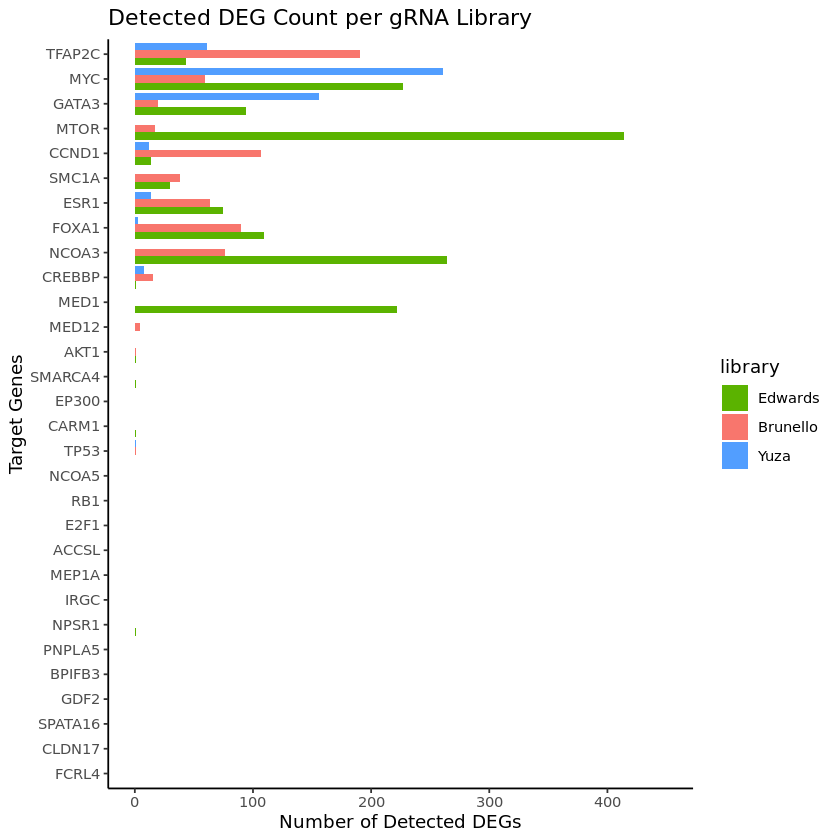

In [11]:
deg_count_plot <- deg_count %>% 
                        ggplot(aes(x=genes, y=deg_count, fill=library)) +
                              geom_col(stat="identity", position=position_dodge()) +
                              ylim(0, 450) + 
                              coord_flip() + 
                              theme_bw() +
                              scale_fill_manual(values=rev(c('#529EFF', '#F8766D', '#5BB300'))) +
                              scale_x_discrete(limits = rev(levels(deg_count$genes))) +
                              theme(panel.border = element_blank(),
                                    plot.background = element_blank(),
                                    panel.grid.major = element_blank(),
                                    panel.grid.minor = element_blank(),
                                    axis.line = element_line(color = 'black')) +
                              labs(x='Target Genes', y='Number of Detected DEGs', title='Detected DEG Count per gRNA Library')
                           
deg_count_plot

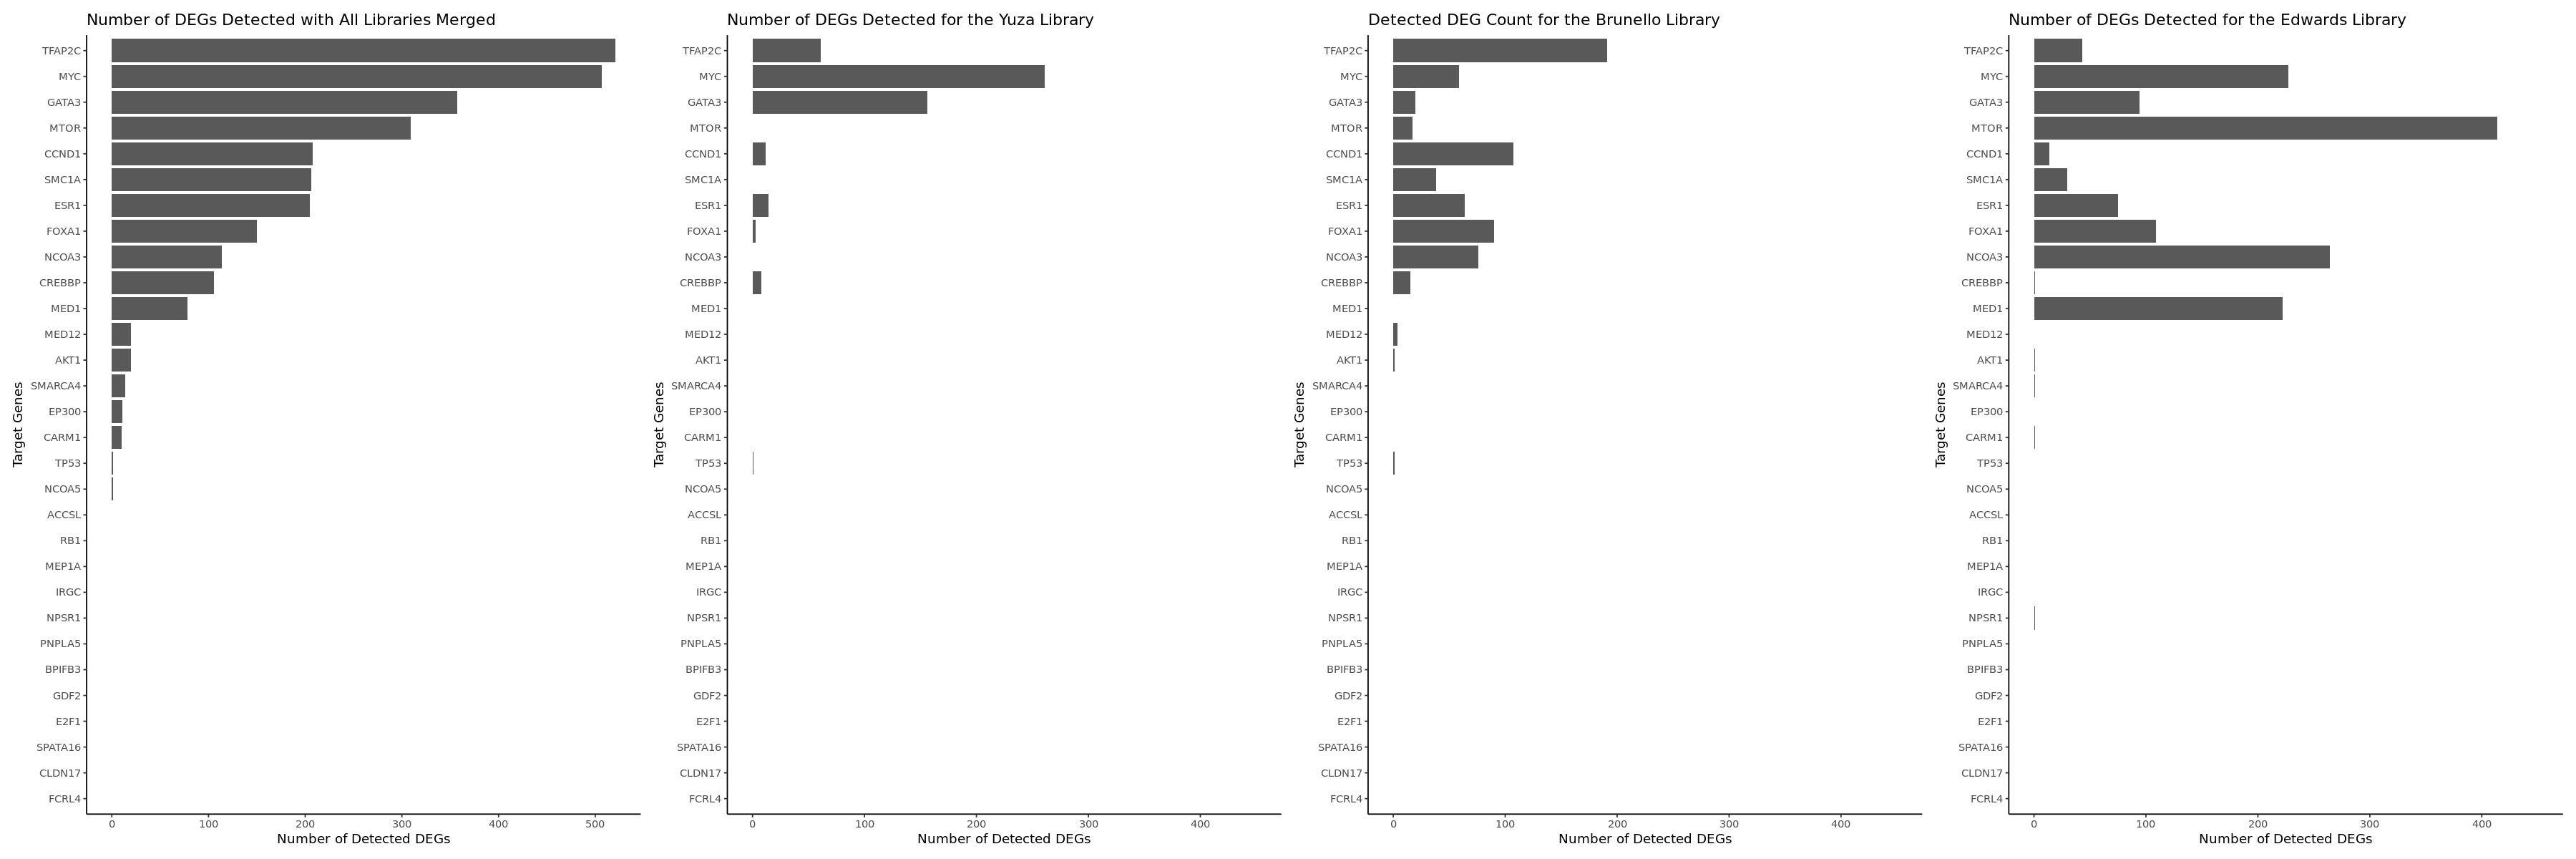

In [12]:
options(repr.plot.width=30, repr.plot.height=10)
merged_deg_plot | yuza_deg_plot | brunello_deg_plot | edwards_deg_plot

In [13]:
merged_deg_count$deg_count %>% sum

[1] 2838

### Yuza Library Differential Gene Expression Results

In [14]:
bar_plot_order = reorder(merged_deg_count$genes, merged_deg_count$deg_count)

yuza_df <- yuza_df %>% filter(target_gene %in% merged_deg_count$genes)
merged_df <- merged_df %>% filter(target_gene %in% merged_deg_count$genes)
edwards_df <- edwards_df %>% filter(target_gene %in% merged_deg_count$genes)
brunello_df <- brunello_df %>% filter(target_gene %in% merged_deg_count$genes)

yuza_df$target_gene <- factor(yuza_df$target_gene, levels=merged_deg_count$genes)
merged_df$target_gene <- factor(merged_df$target_gene, levels=merged_deg_count$genes)
edwards_df$target_gene <- factor(edwards_df$target_gene, levels=merged_deg_count$genes)
brunello_df$target_gene <- factor(brunello_df$target_gene, levels=merged_deg_count$genes)

yuza_df <- yuza_df %>% arrange(target_gene)
merged_df <- merged_df %>% arrange(target_gene)
edwards_df <- edwards_df %>% arrange(target_gene)
brunello_df <- brunello_df %>% arrange(target_gene)

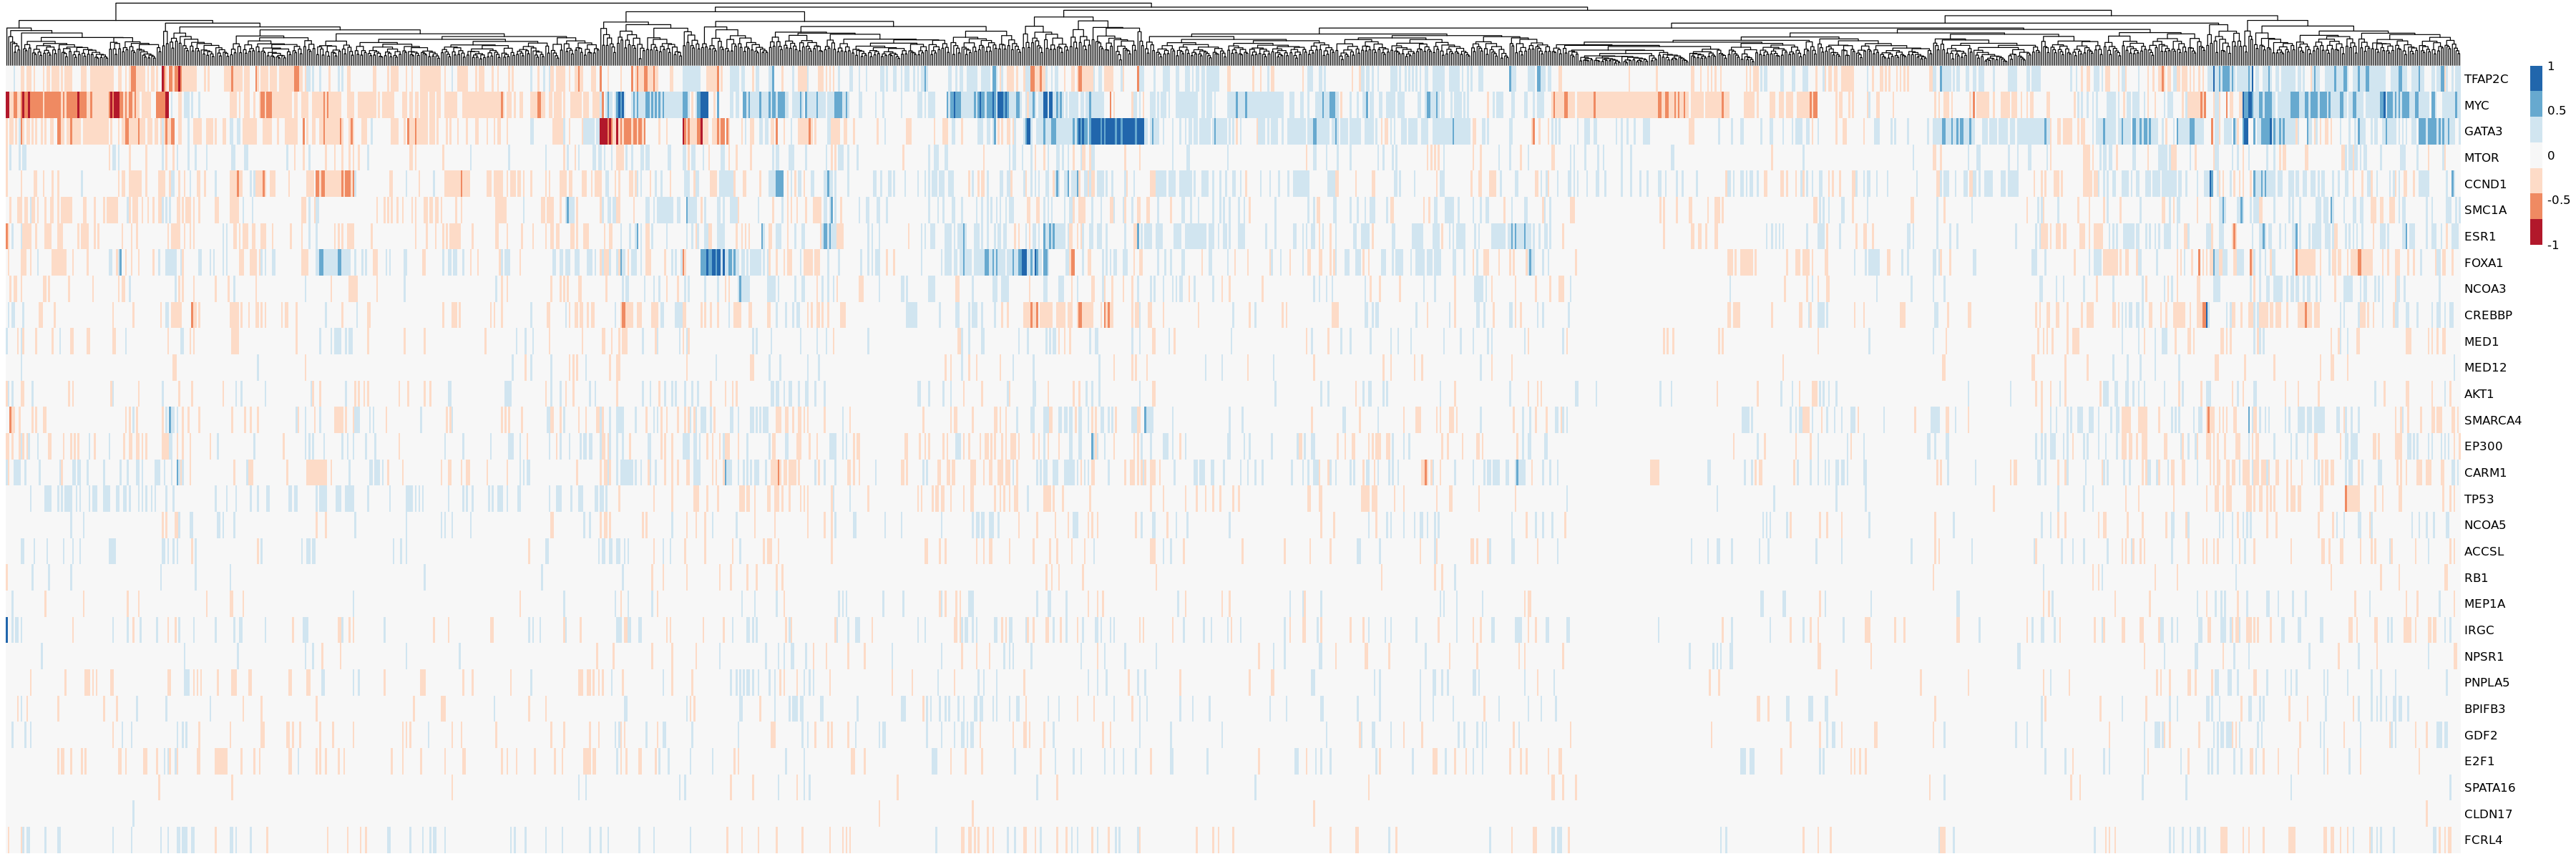

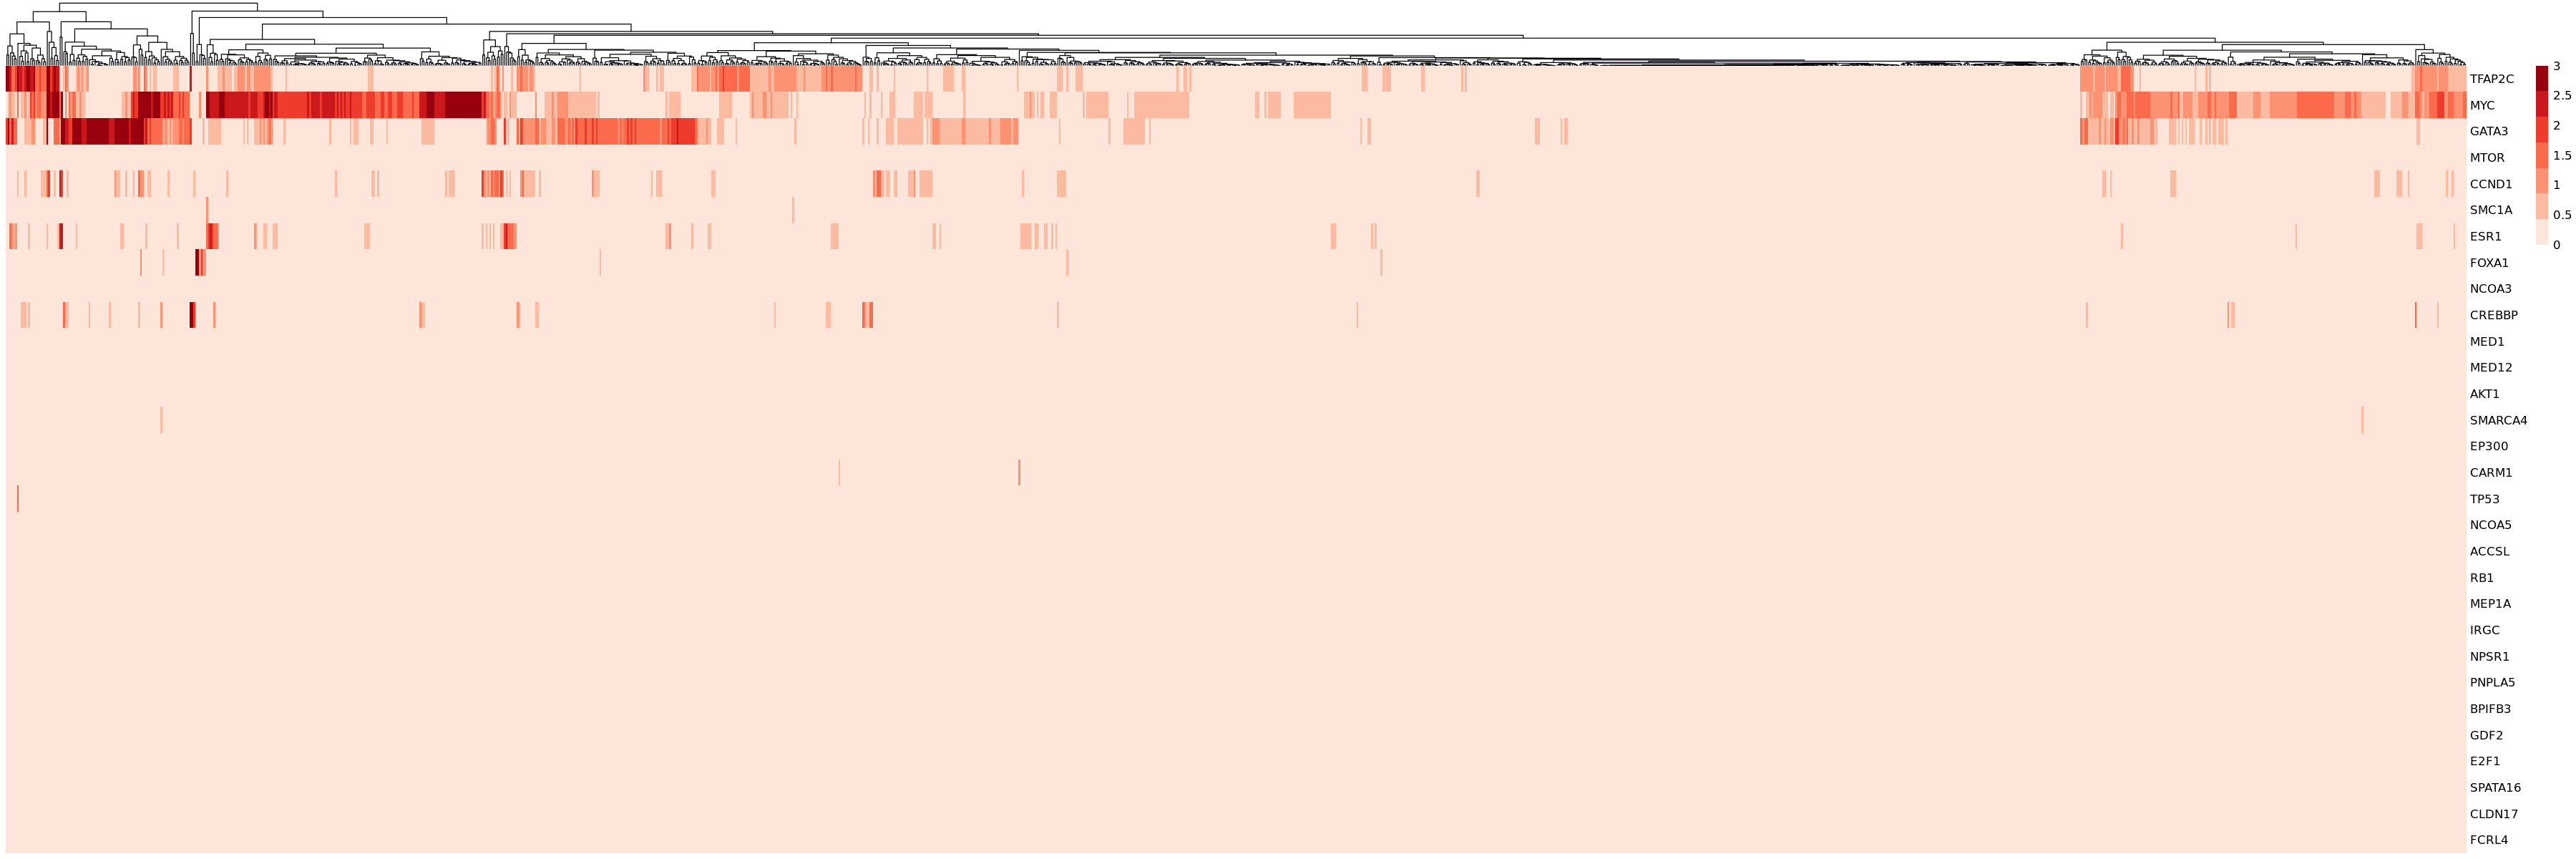

In [15]:
# some manual filtering to improve the heatmap appearance
yuza_df$logfc[yuza_df$logfc > 1] = 1
yuza_df$logfc[yuza_df$logfc < -1] = -1

yuza_df$log_padj[yuza_df$log_padj > 3] = 3

# creating matrix for heatmaps
logfc_mat = heatmap_matrix(yuza_df, uni_degs, 'logfc')
padj_mat = heatmap_matrix(yuza_df, uni_degs, 'log_padj')

# logfc_mat = logfc_mat[genes_levels, ]
# padj_mat = padj_mat[genes_levels, ]
# plotting log folc change and adjusted p-value
yuza_heat = pheatmap(logfc_mat, color=logfc_palette, cluster_rows=FALSE, show_colnames=FALSE)
pheatmap(padj_mat, color=padj_palette, cluster_rows=FALSE, show_colnames=FALSE)

### Brunello Library Differential Gene Expression Results

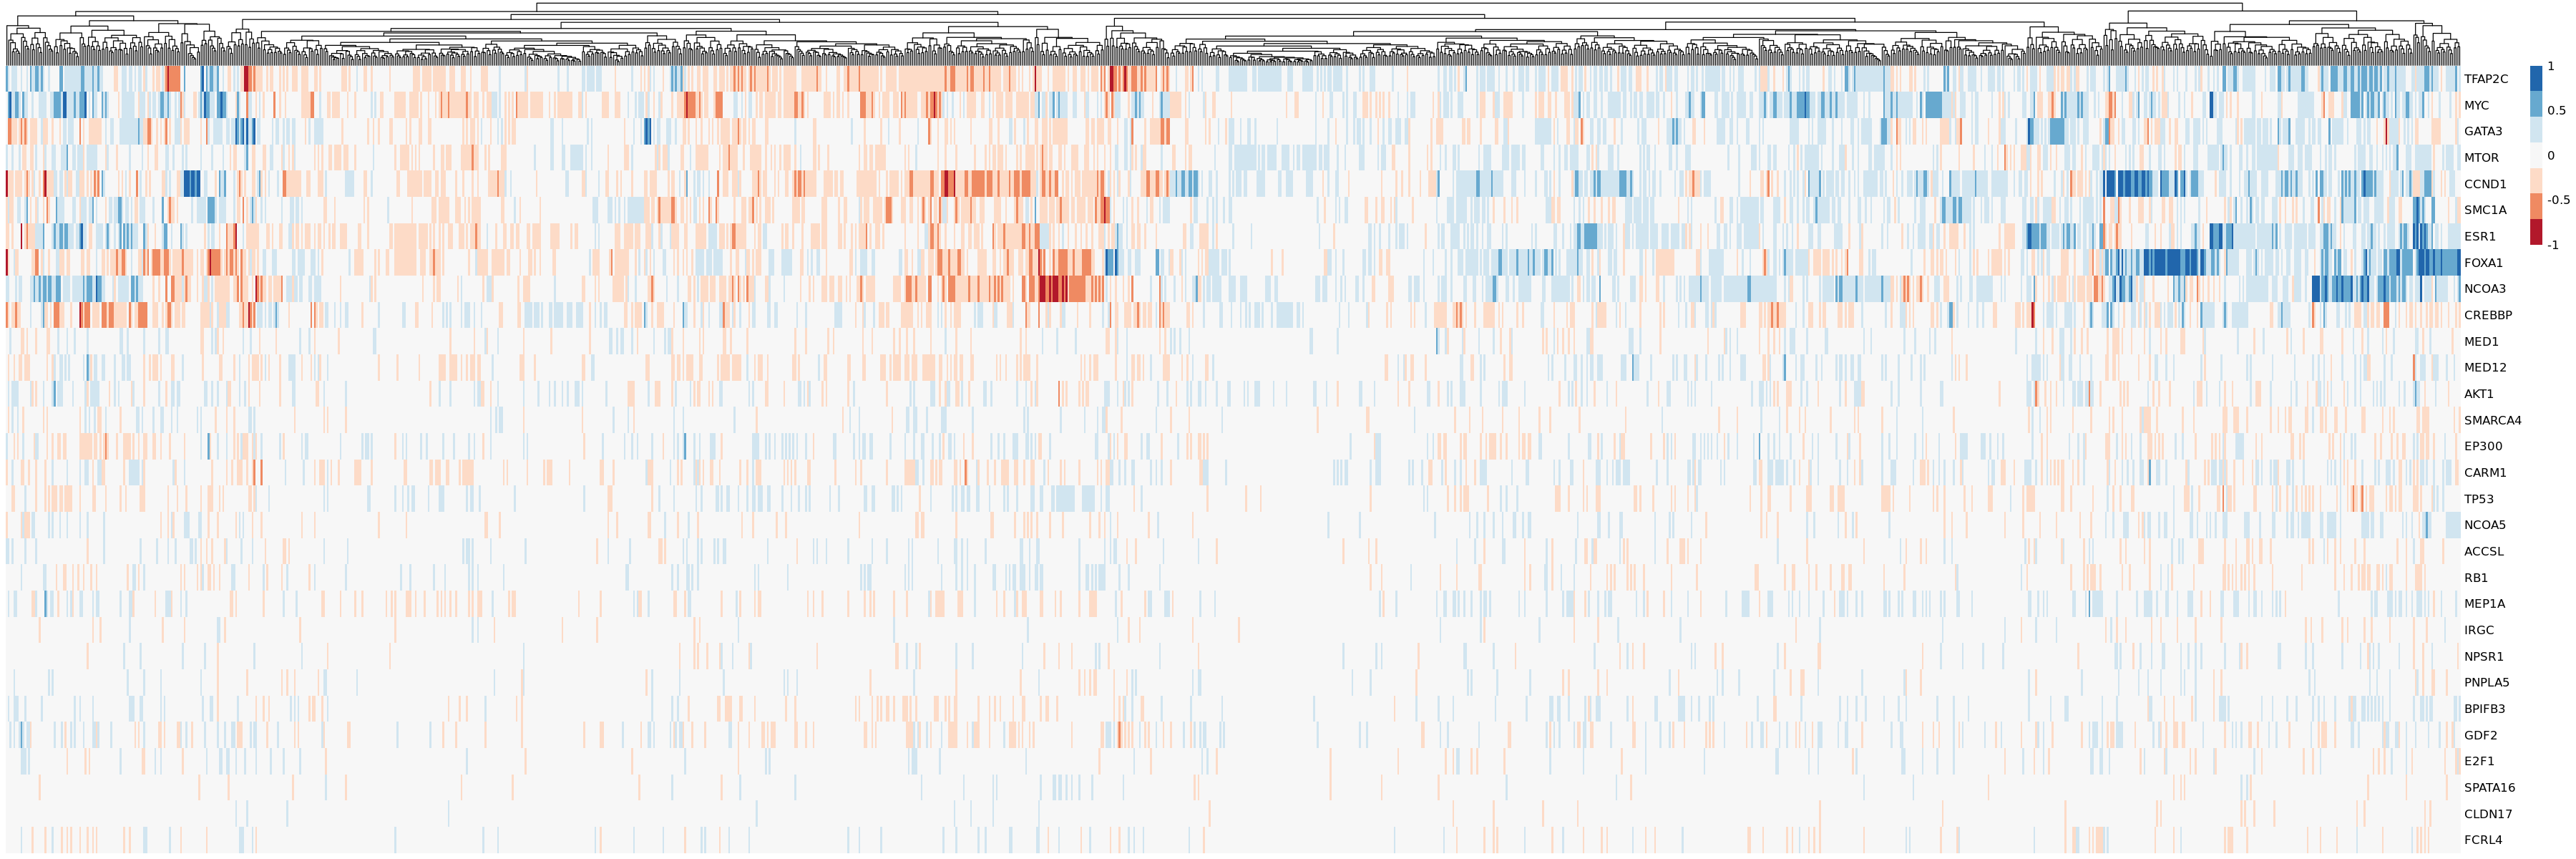

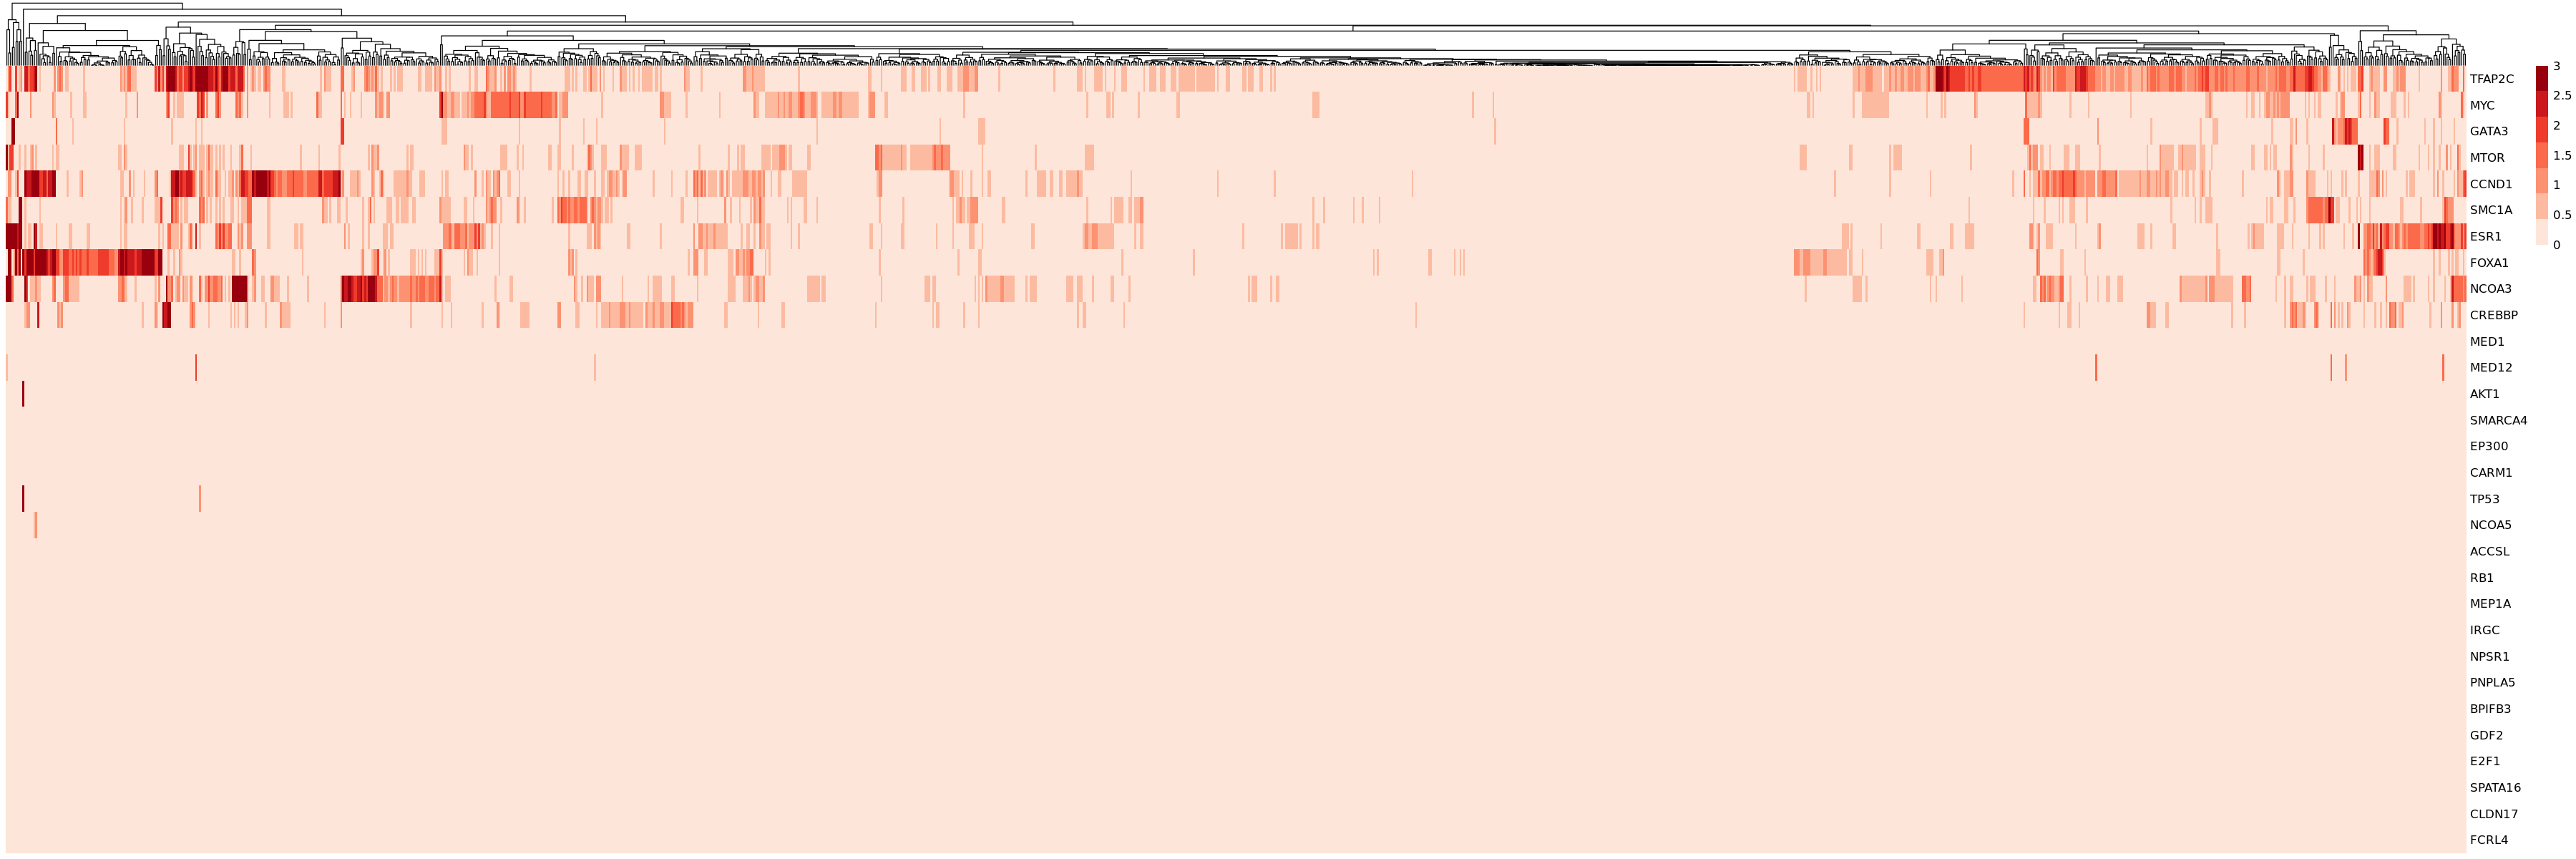

In [16]:
# some manual filtering to improve the heatmap appearance
brunello_df$logfc[brunello_df$logfc > 1] = 1
brunello_df$logfc[brunello_df$logfc < -1] = -1

brunello_df$log_padj[brunello_df$log_padj > 3] = 3

# creating matrix for heatmaps
logfc_mat = heatmap_matrix(brunello_df, uni_degs, 'logfc')
padj_mat = heatmap_matrix(brunello_df, uni_degs, 'log_padj')

# plotting log folc change and adjusted p-value
brunello_heat = pheatmap(logfc_mat, color=logfc_palette, cluster_rows=FALSE, show_colnames=FALSE)
pheatmap(padj_mat, color=padj_palette, cluster_rows=FALSE, show_colnames=FALSE)

### Edwards Library Differential Gene Expression Results

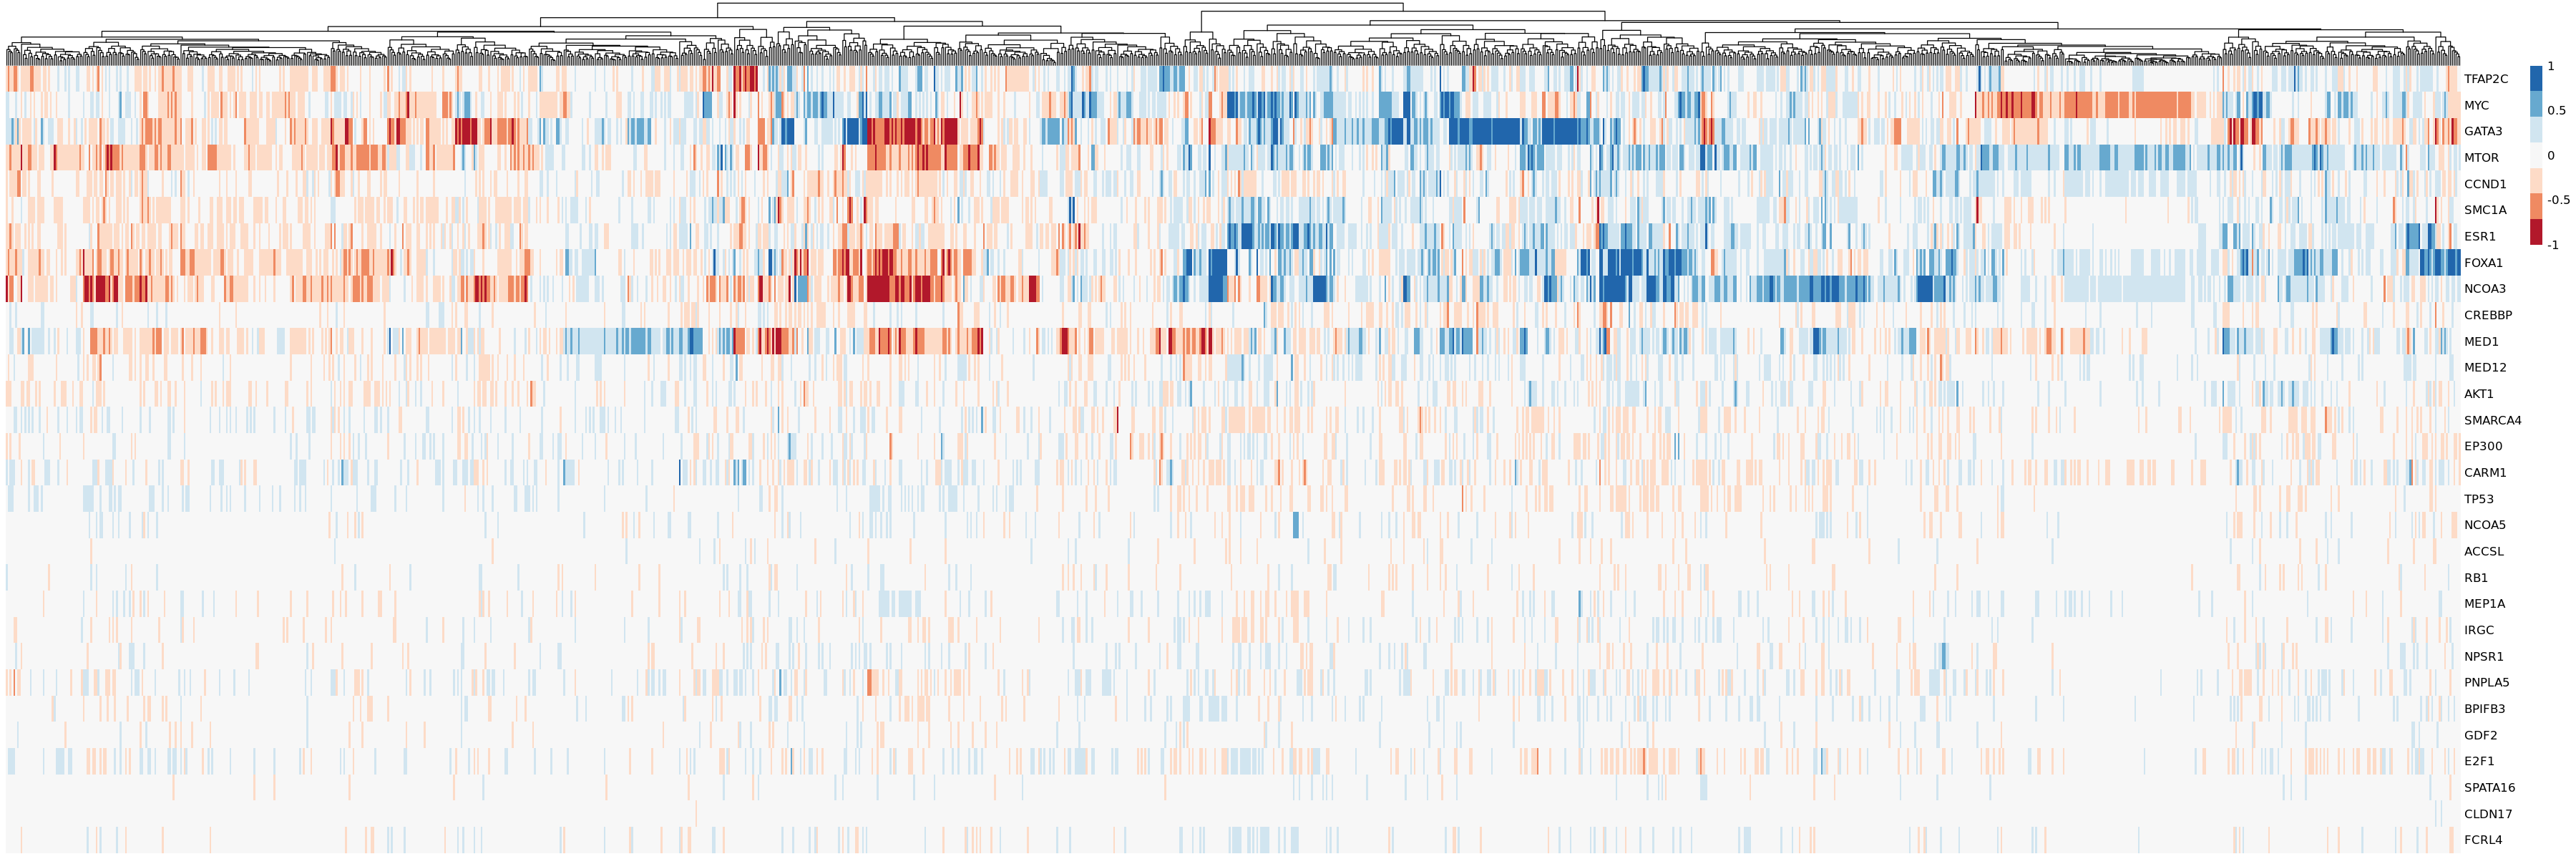

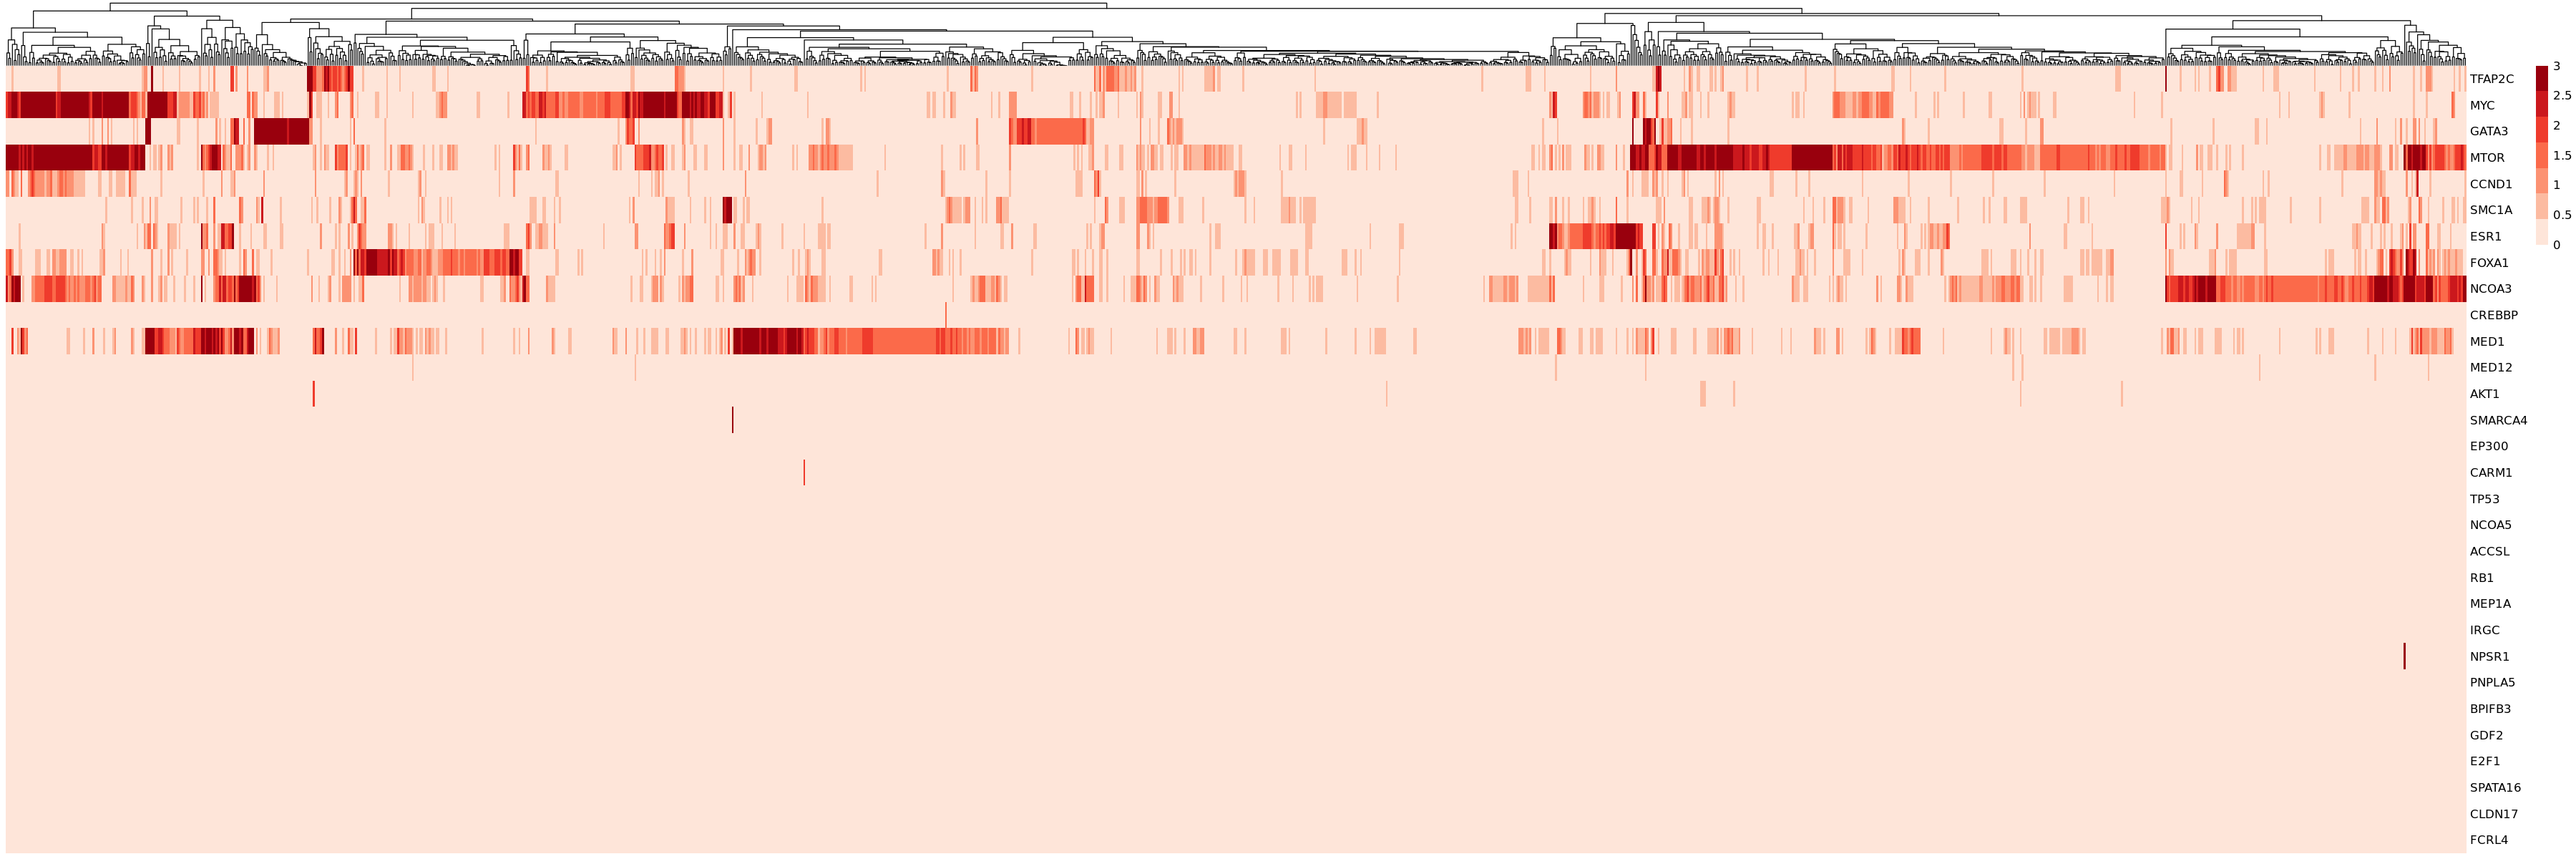

In [17]:
# some manual filtering to improve the heatmap appearance
edwards_df$logfc[edwards_df$logfc > 1] = 1
edwards_df$logfc[edwards_df$logfc < -1] = -1

edwards_df$log_padj[edwards_df$log_padj > 3] = 3

# creating matrix for heatmaps
logfc_mat = heatmap_matrix(edwards_df, uni_degs, 'logfc')
padj_mat = heatmap_matrix(edwards_df, uni_degs, 'log_padj')

# plotting log folc change and adjusted p-value
edwards_heat = pheatmap(logfc_mat, color=logfc_palette, cluster_rows=FALSE, show_colnames=FALSE)
pheatmap(padj_mat, color=padj_palette, cluster_rows=FALSE, show_colnames=FALSE)

## Venn Diagram of Differentially Expressed Genes

In [18]:
yuza_degs = find_deg_of_target_genes(yuza_res, expressed_genes)
edwards_degs = find_deg_of_target_genes(edwards_res, expressed_genes)
brunello_degs = find_deg_of_target_genes(brunello_res, expressed_genes)

degs_list = list(Yuza=yuza_degs,
                 Edwards=edwards_degs,
                 Brunello=brunello_degs)

Non-Expressed Gene:MEP1A...

Non-Expressed Gene:PNPLA5...

Non-Expressed Gene:SPATA16...

Non-Expressed Gene:CLDN17...

Non-Expressed Gene:ACCSL...

Non-Expressed Gene:NPSR1...

Non-Expressed Gene:GDF2...

Non-Expressed Gene:FCRL4...

Non-Expressed Gene:IRGC...

Non-Expressed Gene:BPIFB3...

Non-Expressed Gene:ACCSL...

Non-Expressed Gene:MEP1A...

Non-Expressed Gene:IRGC...

Non-Expressed Gene:NPSR1...

Non-Expressed Gene:GDF2...

Non-Expressed Gene:BPIFB3...

Non-Expressed Gene:SPATA16...

Non-Expressed Gene:PNPLA5...

Non-Expressed Gene:FCRL4...

Non-Expressed Gene:CLDN17...

Non-Expressed Gene:IRGC...

Non-Expressed Gene:MEP1A...

Non-Expressed Gene:ACCSL...

Non-Expressed Gene:GDF2...

Non-Expressed Gene:BPIFB3...

Non-Expressed Gene:NPSR1...

Non-Expressed Gene:PNPLA5...

Non-Expressed Gene:SPATA16...

Non-Expressed Gene:FCRL4...

Non-Expressed Gene:CLDN17...



In [19]:
norm_venn = ggvenn(degs_list, c("Yuza", "Edwards", "Brunello")) 
no_perc_venn = ggvenn(degs_list, show_percentage=FALSE, c("Yuza", "Edwards", "Brunello")) 

Warning message in sprintf("%d", n, 100 * n/sum(n)):
“one argument not used by format '%d'”


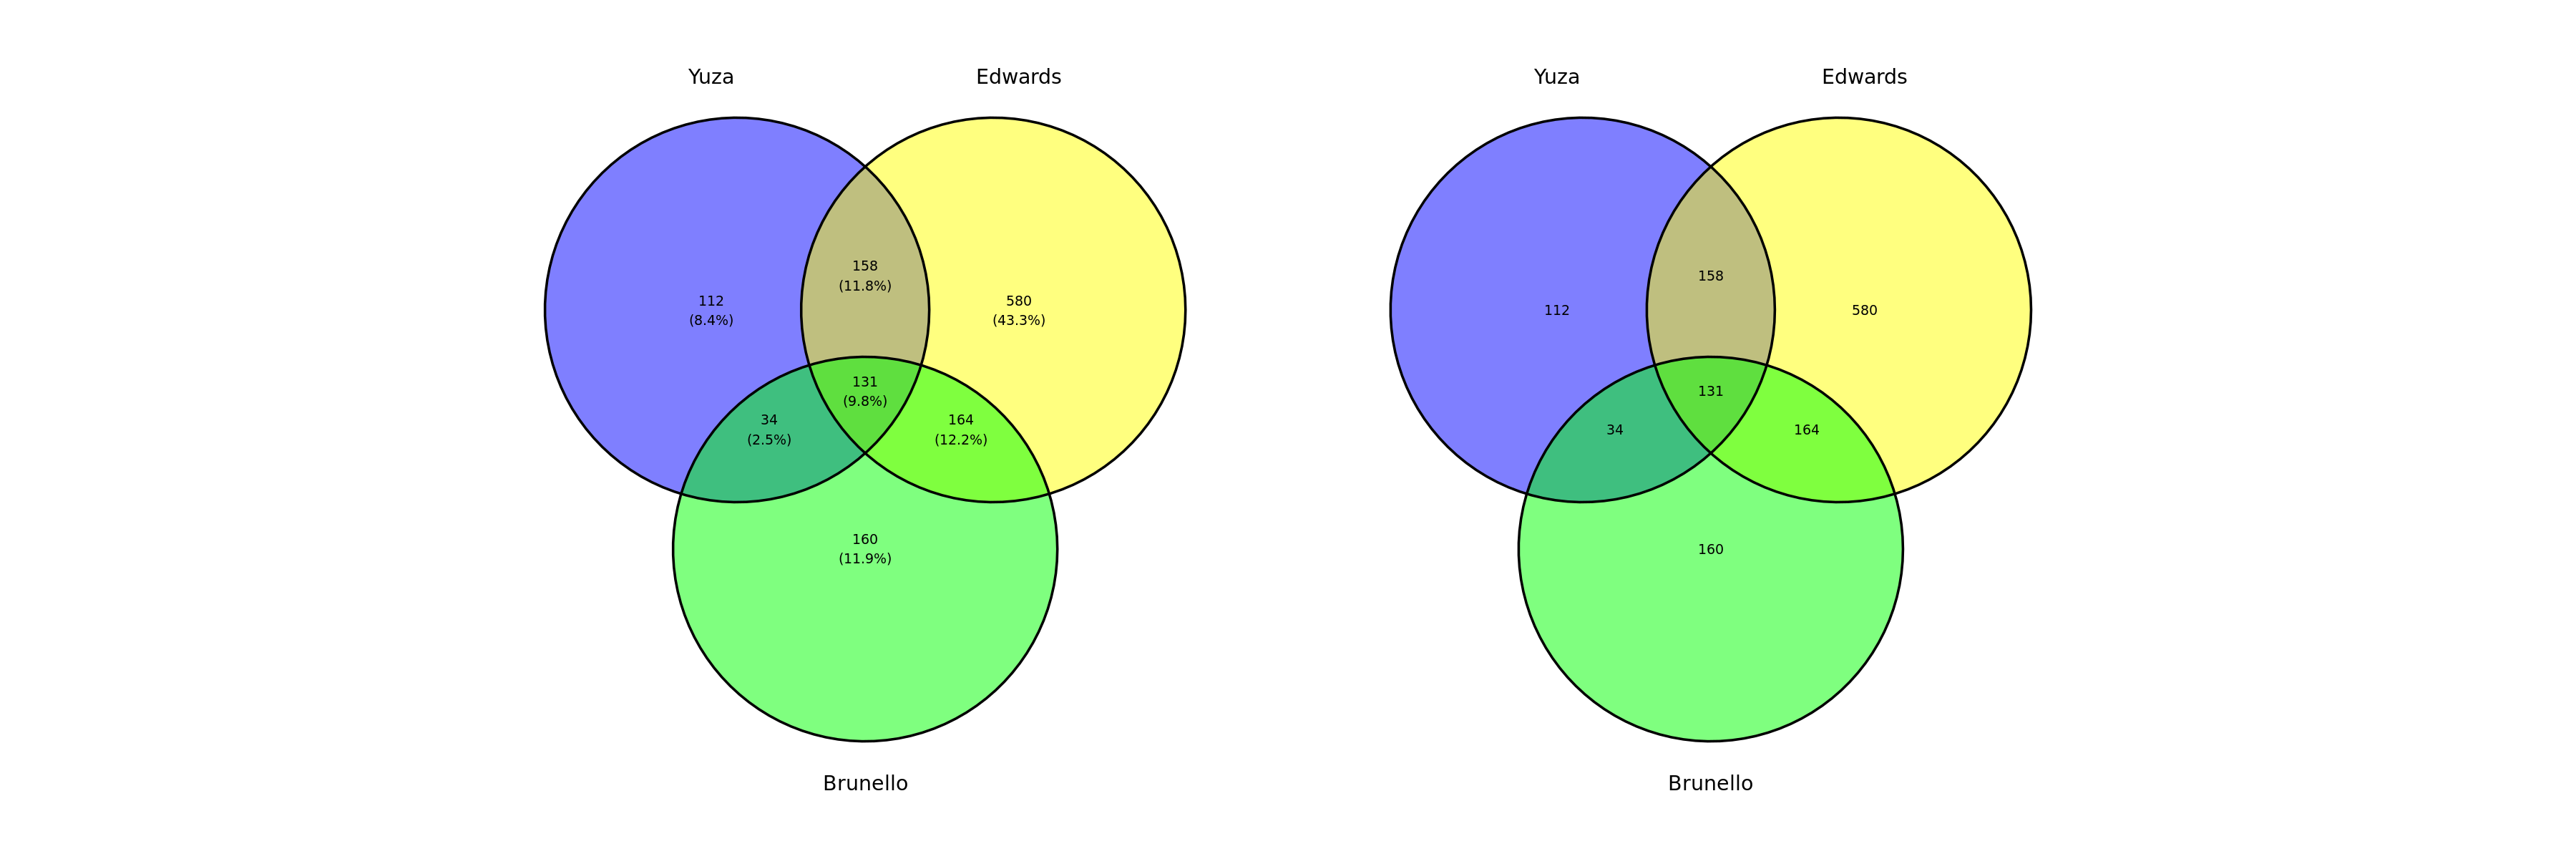

In [20]:
norm_venn | no_perc_venn

In [21]:
ggsave("normal_venn_diagram.eps", plot=norm_venn, height=8, width=8, units="in",device = "eps")
ggsave("percentage_venn_diagram.eps", plot=no_perc_venn, height=8, width=8, units="in",device = "eps")

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


# Differential Expression Analysis using all Cells Regardless of Library

This can be viewed as an optimial performance profile as it contains 3x the cells than an individual library does on average.

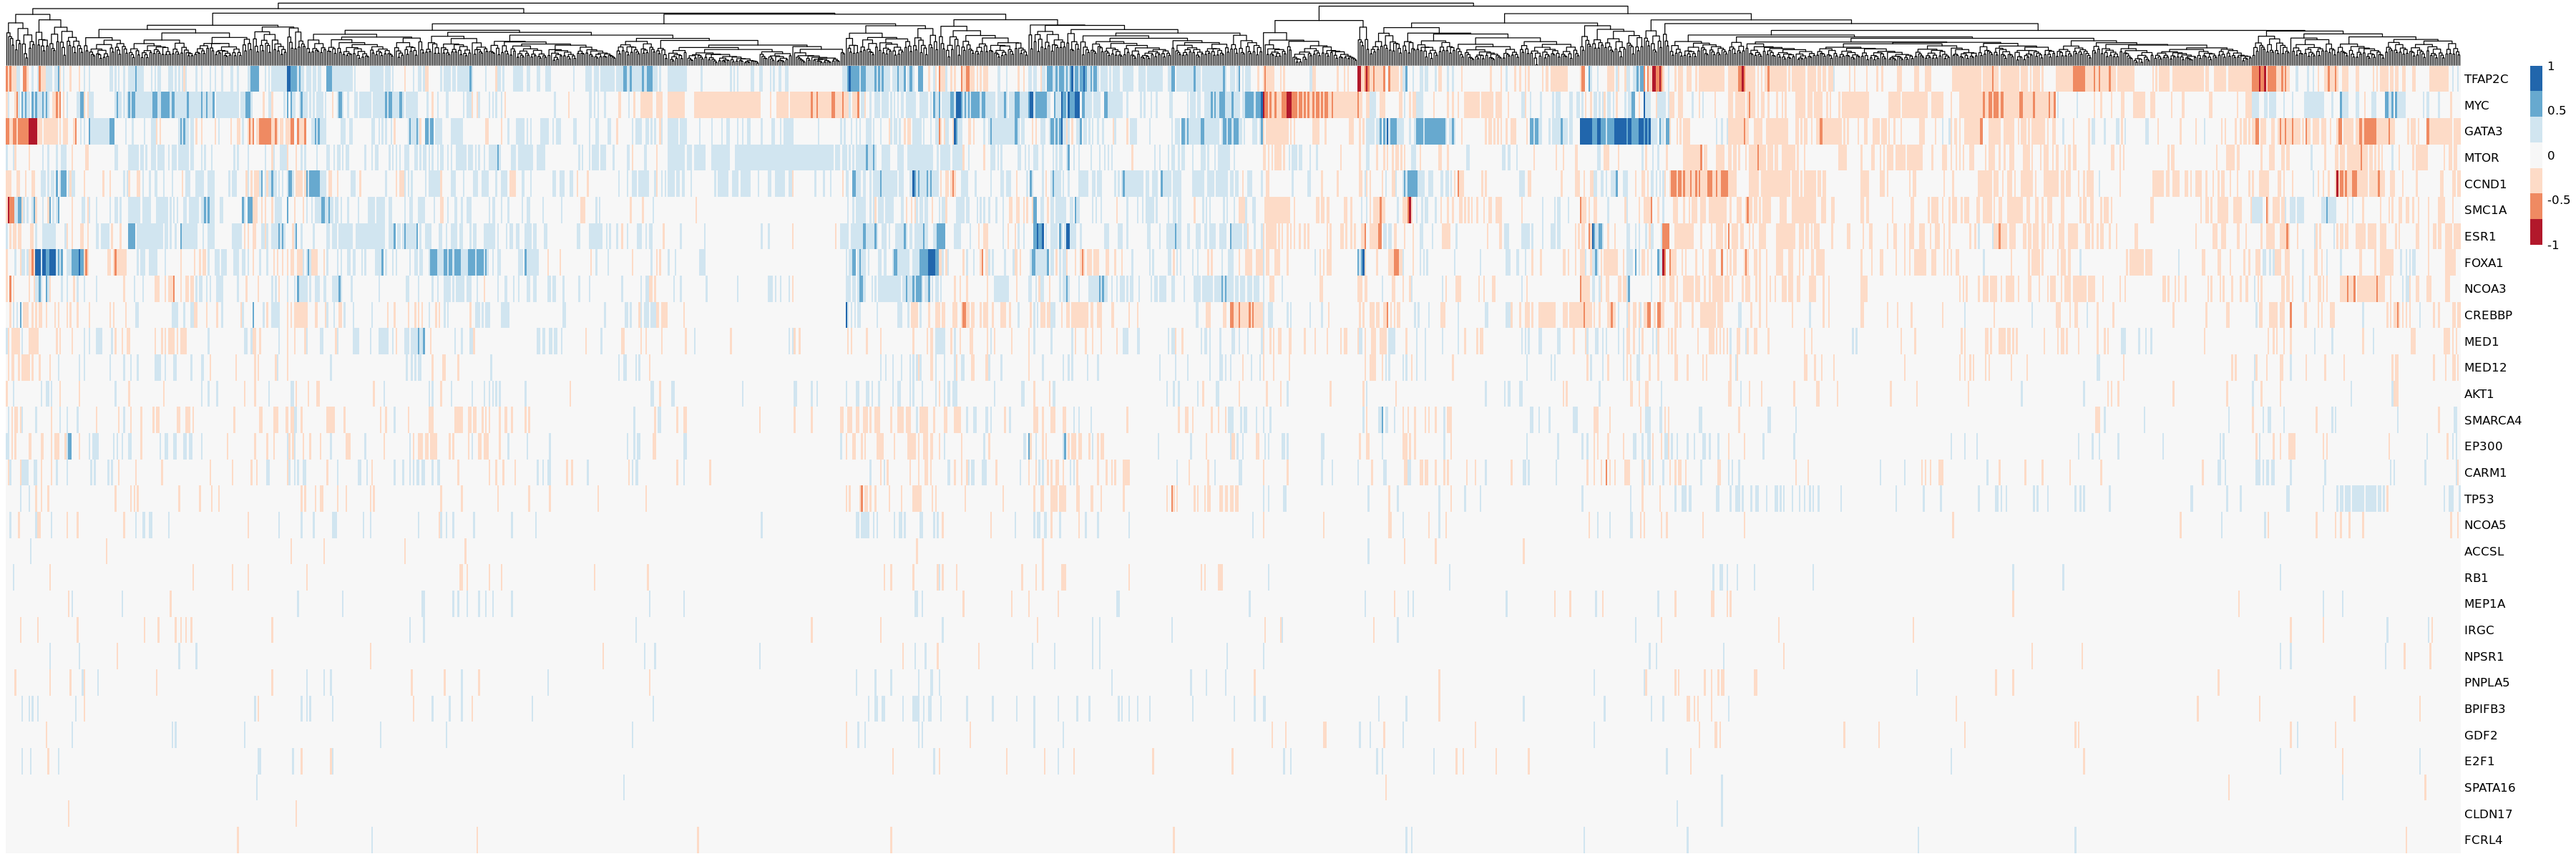

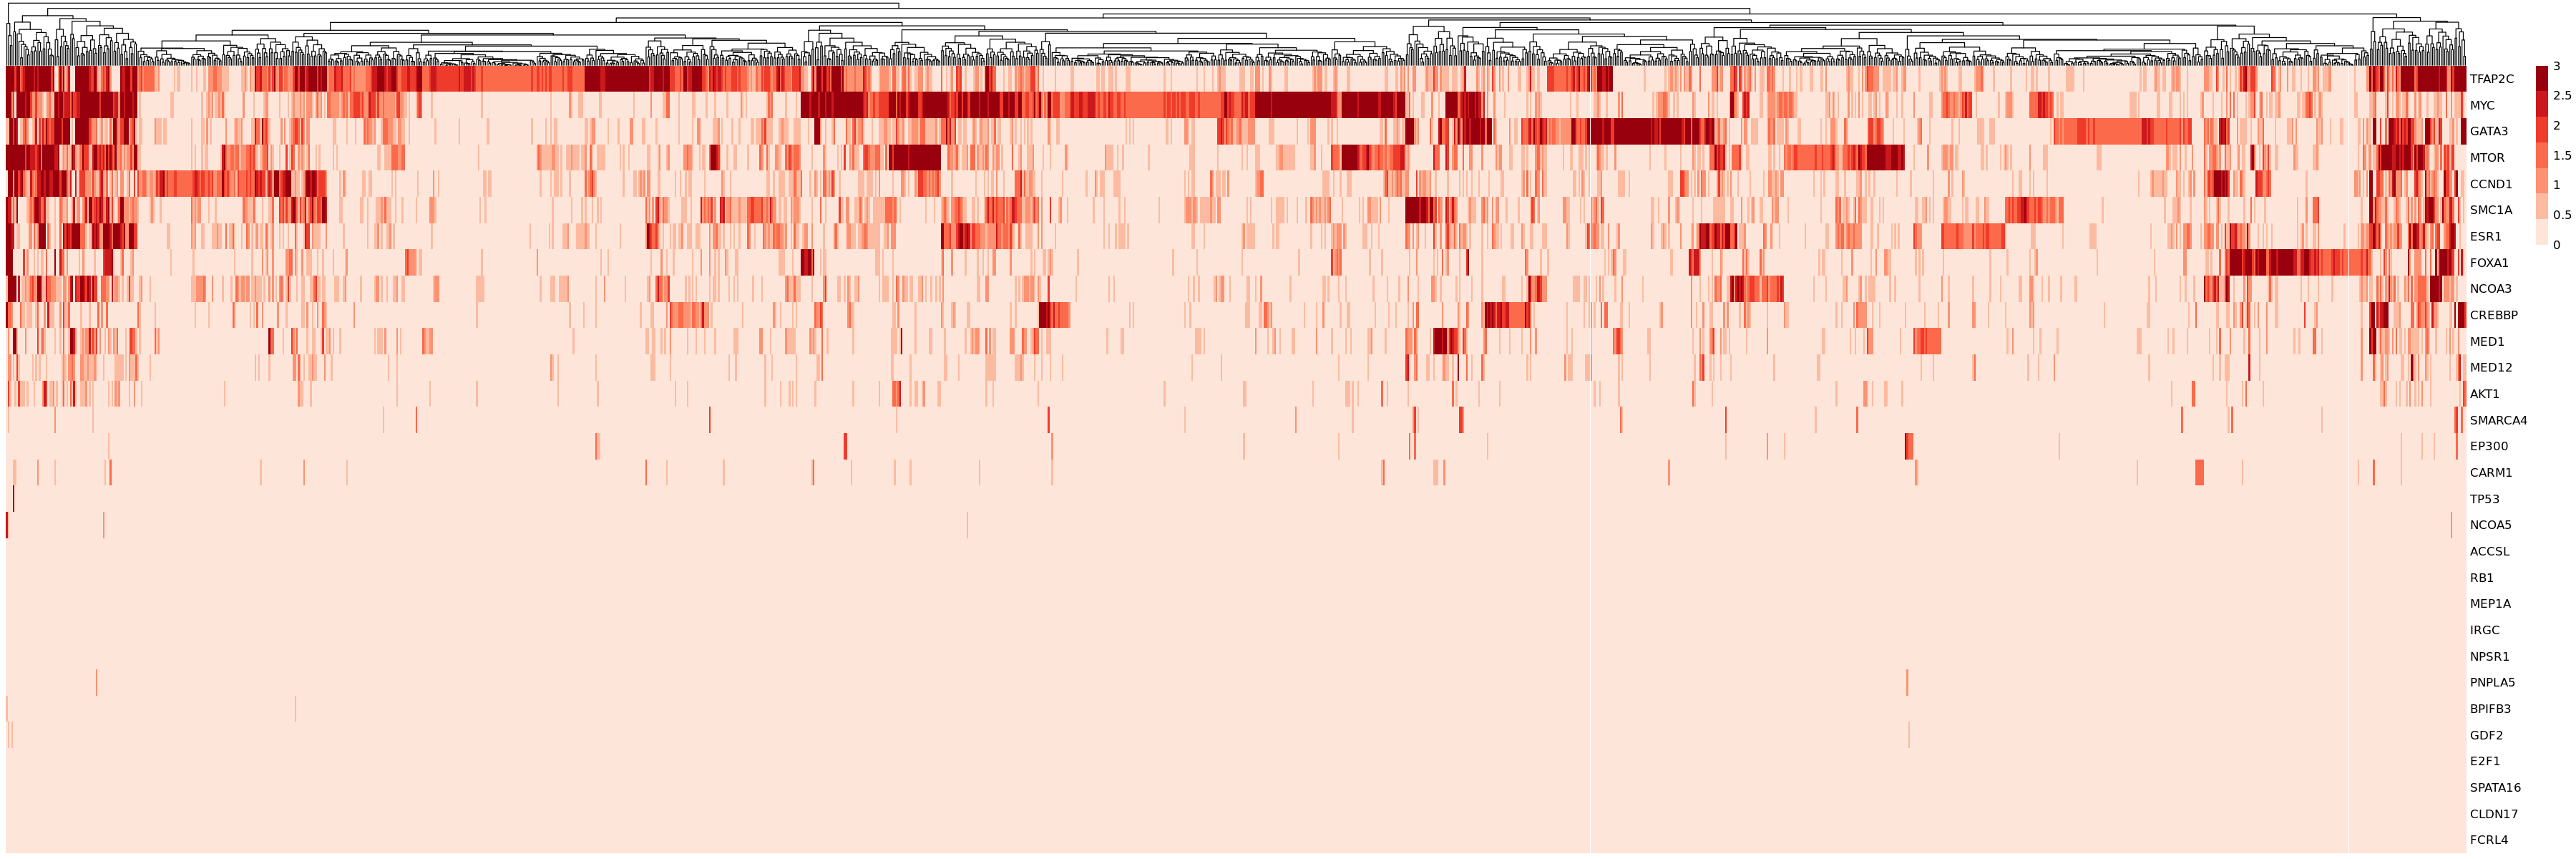

In [22]:
# some manual filtering to improve the heatmap appearance
merged_df$logfc[merged_df$logfc > 1] = 1
merged_df$logfc[merged_df$logfc < -1] = -1
merged_df$log_padj[merged_df$log_padj > 3] = 3
merged_df <- merged_df[!duplicated(merged_df), ]

# creating matrix for heatmaps
logfc_mat = heatmap_matrix(merged_df, merged_degs, 'logfc')
padj_mat = heatmap_matrix(merged_df, merged_degs, 'log_padj')

# creating annotation column dataframe
anno_col_df = data.frame(Category = gene_metadata[rownames(logfc_mat), c("Category")])
rownames(anno_col_df) = rownames(logfc_mat)

# plotting log folc change and adjusted p-value
merged_heat = pheatmap(logfc_mat, color=logfc_palette, cluster_rows=FALSE, show_colnames=FALSE)
pheatmap(padj_mat, color=padj_palette, cluster_rows=FALSE, show_colnames=FALSE)

In [23]:
# ggsave("yuza_deg_count.eps", plot=yuza_deg_plot, height=8, width=8, units="in",device = "eps")
# ggsave("brunello_deg_count.eps", plot=brunello_deg_plot, height=8, width=8, units="in",device = "eps")
# ggsave("edwards_deg_count.eps", plot=edwards_deg_plot, height=8, width=8, units="in",device = "eps")
# ggsave("merged_deg_count.eps", plot=merged_deg_plot, height=8, width=8, units="in",device = "eps")
# ggsave("deg_count.eps", plot=deg_count_plot, height=8, width=8, units="in", device = "eps")

# ggsave("yuza_heatmaps.png", plot=yuza_heat, height=8, width=8, units="in",device = "png")
# ggsave("brunello_heatmaps.png", plot=brunello_heat, height=8, width=8, units="in",device = "png")
# ggsave("edwards_heatmaps.png", plot=edwards_heat, height=8, width=8, units="in",device = "png")
# ggsave("merged_heatmaps.png", plot=merged_heat, height=8, width=8, units="in",device = "png")